In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

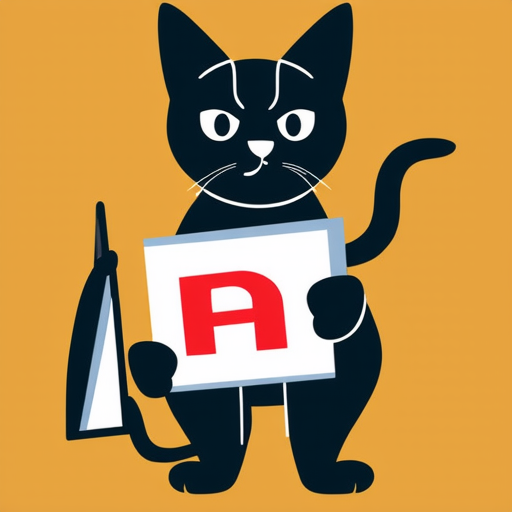

In [2]:
import torch
from stable_diffusion3 import StableDiffusion3Pipeline, retrieve_timesteps

# pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float32)
pipe = StableDiffusion3Pipeline.from_pretrained('/mnt/bn/us-aigc-temp/henry/data/unilatent/epoch_0_step_79999/', torch_dtype=torch.float32)
pipe = pipe.to("cuda")

image = pipe(
    "A cat holding a sign that says hello world",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
    height=512,
    width=512,
).images[0]
image

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# image_pt = torch.tensor(np.array(image), device='cuda').half().permute(2, 0, 1)[None] / 127.5 - 1
# out = pipe.vae.encode(image_pt).latent_dist.sample()
# latent = (out - pipe.vae.config.shift_factor) * pipe.vae.config.scaling_factor

# pipe.scheduler.set_timesteps(1000)
# index = torch.randint(0, 1000, size=(1,))
# with torch.no_grad():
#     model_output, target = pipe.train_step(latent, "A cat holding a sign that says hello world", index)
#     print(index, ((model_output - target) ** 2).mean())

In [15]:
from diffusion.utils.misc import read_config
from diffusion.data.builder import build_dataset, build_dataloader
from diffusion.utils.data_sampler import AspectRatioBatchSampler
from torch.utils.data import RandomSampler

config_path='/mnt/bn/us-aigc-temp/henry/mm-diffusion-pixart/configs/zjl_test/textart_ud_sg.py'
config = read_config(config_path)

In [16]:
data_config = {
    'type': 'FlexibleInternalDataMS',
    'roots': ['/mnt/bn/us-aigc-temp/henry/coco_2014/val/val2014/'],
    'json_lst': ['/mnt/bn/us-aigc-temp/henry/test.json'],
    'load_vae_feat': False,
    'load_t5_feat': False
}
dataset = build_dataset(
    data_config, resolution=512, aspect_ratio_type='ASPECT_RATIO_512',
    real_prompt_ratio=0.0, max_length=77,
)
batch_sampler = AspectRatioBatchSampler(sampler=RandomSampler(dataset), dataset=dataset,
                                    batch_size=4, aspect_ratios=dataset.aspect_ratio, drop_last=True,
                                    ratio_nums=dataset.ratio_nums, config=config, valid_num=config.valid_num)
dataloader = build_dataloader(dataset, batch_sampler=batch_sampler, num_workers=config.num_workers)

2024-07-22 12:03:41,148 - PixArt - INFO - Constructing dataset FlexibleInternalDataMS...
2024-07-22 12:03:41,150 - PixArt - INFO - T5 max token length: 77
2024-07-22 12:03:41,150 - PixArt - INFO - ratio of real user prompt: 0.0
2024-07-22 12:03:41,186 - PixArt - INFO - /mnt/bn/us-aigc-temp/henry/test.json data volume: 5000
2024-07-22 12:03:41,206 - PixArt - INFO - Dataset FlexibleInternalDataMS constructed. time: 0.06 s, length (use/ori): 5000/5000
2024-07-22 12:03:41,207 - PixArt - WARNING - Using valid_num=0 in config file. Available 40 aspect_ratios: ['0.25', '0.26', '0.27', '0.28', '0.32', '0.33', '0.35', '0.4', '0.42', '0.48', '0.5', '0.52', '0.57', '0.6', '0.68', '0.72', '0.78', '0.82', '0.88', '0.94', '1.0', '1.07', '1.13', '1.21', '1.29', '1.38', '1.46', '1.67', '1.75', '2.0', '2.09', '2.4', '2.5', '2.89', '3.0', '3.11', '3.62', '3.75', '3.88', '4.0']


In [17]:
# # FUTURE: might want to consider https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth_lora_sd3.py#L1655
# from diffusers.training_utils import (
#     compute_density_for_timestep_sampling,
#     compute_loss_weighting_for_sd3,
# )

In [18]:
from tqdm import tqdm
from diffusers import get_cosine_schedule_with_warmup
from accelerate import Accelerator
num_epochs = 1

optimizer = torch.optim.AdamW(lr=1e-5, params=pipe.parameters())
lr_scheduler = get_cosine_schedule_with_warmup(
            optimizer=optimizer,
            num_warmup_steps=50,
            num_training_steps=(len(dataloader) * num_epochs),
        )

accelerator = Accelerator(
        # mixed_precision=config.mixed_precision,
        # mixed_precision='no',
        mixed_precision='fp16',
        gradient_accumulation_steps=config.gradient_accumulation_steps
    )

pipe.transformer, optimizer, lr_scheduler = accelerator.prepare(pipe.transformer, optimizer, lr_scheduler)
pipe.text_encoder, pipe.text_encoder_2 = accelerator.prepare(pipe.text_encoder, pipe.text_encoder_2)

progbar = tqdm(dataloader)
for step, batch in enumerate(progbar):
    optimizer.zero_grad()
    
    # prepare data
    image_tensor, prompt = batch[0], batch[1]
    latent = pipe.vae.encode(image_tensor.to('cuda')).latent_dist.sample()
    latent = (latent - pipe.vae.config.shift_factor) * pipe.vae.config.scaling_factor
    index = torch.randint(0, 1000, size=(len(latent),))

    # run model
    model_output, target = pipe.train_step(latent, prompt, index)

    assert (model_output).isfinite().all(), model_output
    assert (target).isfinite().all(), target
    loss = ((model_output - target) ** 2).mean()
    accelerator.backward(loss)

    grad_norm = accelerator.clip_grad_norm_(pipe.parameters(), 0.01)

    for p in pipe.parameters():
        if p.grad is not None:
            torch.nan_to_num(p.grad, nan=0, posinf=1e5, neginf=-1e5, out=p.grad)

    optimizer.step()
    lr_scheduler.step()
    progbar.set_description(f"loss: {loss.item():.3f}")

Detected kernel version 5.4.143, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
  0%|          | 0/1250 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

In [ ]:
pipe.save_pretrained('/mnt/bn/us-aigc-temp/henry/data/unilatent/model/')

self.text_encoder_3=None of type <class 'NoneType'> cannot be saved.


In [ ]:
# from tqdm import tqdm
# from diffusers import get_cosine_schedule_with_warmup
# from accelerate import Accelerator
# num_epochs = 1

# optimizer = torch.optim.AdamW(lr=1e-4, params=pipe.parameters())
# lr_scheduler = get_cosine_schedule_with_warmup(
#             optimizer=optimizer,
#             num_warmup_steps=50,
#             num_training_steps=(len(dataloader) * num_epochs),
#         )

# accelerator = Accelerator(
#         mixed_precision=config.mixed_precision,
#         gradient_accumulation_steps=config.gradient_accumulation_steps
#     )

# pipe = accelerator.prepare(pipe)

# progbar = tqdm(dataloader)
# for step, batch in enumerate(progbar):
#     optimizer.zero_grad()
    
#     # prepare data
#     image_tensor, prompt = batch[0], batch[1]
#     latent = pipe.vae.encode(image_tensor.half().to('cuda')).latent_dist.sample()
#     latent = (latent - pipe.vae.config.shift_factor) * pipe.vae.config.scaling_factor
#     index = torch.randint(0, 1000, size=(len(latent),))

#     # run model
#     model_output, target = pipe.train_step(latent, prompt, index)

#     assert (model_output).isfinite().all(), model_output
#     assert (target).isfinite().all(), target
#     loss = ((model_output - target) ** 2).mean()
#     loss.backward()

#     accelerator.clip_grad_norm_(model.parameters(), config.gradient_clip)
#     optimizer.step()
#     lr_scheduler.step()
#     progbar.set_description(f"loss: {loss.item():.3f}")

In [23]:
import open_clip

model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:laion/CLIP-ViT-bigG-14-laion2B-39B-b160k')
tokenizer = open_clip.get_tokenizer('hf-hub:laion/CLIP-ViT-bigG-14-laion2B-39B-b160k')

model = model.cuda()

In [6]:
from torchvision import transforms

In [18]:
preprocess_tensor = transforms.Compose([
    transforms.Resize(size=224, interpolation=transforms.InterpolationMode.BICUBIC, max_size=None, antialias=True),
    transforms.CenterCrop(size=(224, 224)),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
])

t = torch.randn(size=(1, 3, 512, 512)).clip(0, 1)
y = preprocess_tensor(t)

In [74]:
from transformers import CLIPVisionModel, AutoProcessor

cv = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14-336")
cp = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14-336")

In [84]:
import numpy as np
x = torch.tensor(np.array(image)).float().permute(2, 0, 1)[None] / 255.
print(x.shape, x.min(), x.max(), type(x), x.dtype)
z = cp.image_processor(x, do_rescale=False, return_type='pt')['pixel_values'][0]
print(z.shape, type(z))

cv(z)

Unused or unrecognized kwargs: return_type.


torch.Size([1, 3, 512, 512]) tensor(0.) tensor(1.) <class 'torch.Tensor'> torch.float32
(3, 336, 336) <class 'numpy.ndarray'>


AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [121]:
z = cp.image_processor(image)['pixel_values'][0]
z = torch.tensor(z)
x = torch.tensor(np.array(image)).float().permute(2, 0, 1)[None] / 255.
x = x.tile((10, 1, 1, 1))
print(x.shape)
# z2 = preprocess_tensor(x)[0]
z2 = cp.image_processor(x, do_rescale=False)['pixel_values'][0]
z2 = torch.tensor(z2)
(z - z2).mean(), (z - z2).std()

torch.Size([10, 3, 512, 512])


(tensor(0.), tensor(0.))

In [124]:
def encode_image(x, device='cpu', dtype=torch.float32):
    if x.min() < 0:
        assert x.min() >= -1.
        x = x * .5 + .5
    
    processed_list = cp.image_processor(x, do_rescale=False)['pixel_values']
    return torch.tensor(np.stack(processed_list)).to(device).type(dtype)

z3 = encode_image(x)

In [127]:
(z3[0] - z).norm()

tensor(0.)

In [88]:
def get_preprocessor(size=336):
    return transforms.Compose([
    transforms.Resize(size=size, interpolation=transforms.InterpolationMode.BICUBIC, max_size=None, antialias=True),
    transforms.CenterCrop(size=(size, size)),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
])

preprocess_tensor = get_preprocessor()

In [51]:
ones = torch.zeros(size=(1, 3, 224, 224))
preprocess_tensor(ones).max()

tensor(-1.4802)